In [1]:
import networkx as nx
import seaborn
import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from time import time

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# Set Seaborn styles & context
seaborn.set_context("paper")
seaborn.set_style('white')

In [4]:
# Read in data and do data pre-processing
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.impute_reassortant_status(G)
G = cf.impute_host_group_name(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [5]:
# Compute proportion reassortant
data_props = cf.edge_proportion_reassortant(G, attr='host_group', exclusions=['Unknown'])
data_props

{'diff_attr': 0.2950776520136878, 'same_attr': 0.10416883097609118}

In [6]:
start = time()
def null_distribution_proportion_reassortant(G):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_group')
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_group', exclusions=['Unknown'])
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G) for i in range(100))
end = time()
print(end - start)

189.01565074920654


In [7]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.121166
same_attr    0.121652
dtype: float64

In [8]:
data = pd.DataFrame([data_props])
data.mean()

diff_attr    0.295078
same_attr    0.104169
dtype: float64

(0, 1)

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


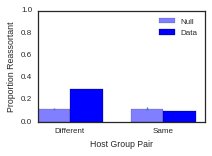

In [9]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.5, yerr=null.std()*5)
ax.bar(ind+width, data.mean(), width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(['Different', 'Same'])
ax.set_xlabel('Host Group Pair')
ax.set_ylabel('Proportion Reassortant')
ax.legend()
ax.set_ylim(0,1)

In [10]:
# Between which host groups are they over-represented or under-represented?

def host_group_domain_graph(G, node_attr):
    """
    Computes the proportion of reassortant representation when crossing between host groups.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n][node_attr]
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc][node_attr]
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [11]:
hg_graph = host_group_domain_graph(G)
hg_graph.edges(data=True)

[('Wild',
  'Wild',
  {'p_reassortant': 0.3066082425390816,
   'reassortant': 1294.5000000000018,
   'total': 4221.999999999998}),
 ('Wild',
  'Domestic',
  {'p_reassortant': 0.44300144300144295,
   'reassortant': 153.5,
   'total': 346.50000000000006}),
 ('Wild',
  'Unknown',
  {'p_reassortant': 0.4405797101449275, 'reassortant': 76.0, 'total': 172.5}),
 ('Wild', 'Human', {'p_reassortant': 0.48, 'reassortant': 6.0, 'total': 12.5}),
 ('Domestic',
  'Domestic',
  {'p_reassortant': 0.1034170812944611,
   'reassortant': 419.1666666666683,
   'total': 4053.166666666683}),
 ('Domestic',
  'Wild',
  {'p_reassortant': 0.27115384615384613, 'reassortant': 70.5, 'total': 260.0}),
 ('Domestic',
  'Unknown',
  {'p_reassortant': 0.4830413715989611,
   'reassortant': 72.00000000000067,
   'total': 149.0555555555555}),
 ('Domestic',
  'Human',
  {'p_reassortant': 0.1259259259259255,
   'reassortant': 8.499999999999986,
   'total': 67.50000000000011}),
 ('Unknown',
  'Wild',
  {'p_reassortant': 0.2586

In [12]:
def null_proportion_hg_reassortant(G, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_group', equally)
    hg_graph_shuf = host_group_domain_graph(G_shuffled)
    
    return hg_graph_shuf

In [13]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_hg_reassortant)(G, equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

185.74109196662903


In [14]:
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in list_of_hg_graphs:
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

summaryG = distr_null_p_reassortant(results)

In [15]:
summaryG.edges(data=True)

[('Wild',
  'Wild',
  {'p_reassortant': [0.12238568995590486,
    0.10333307908625264,
    0.11120349244528424,
    0.11613008228905866,
    0.11895827649046188,
    0.10269666941632695,
    0.1384559059405026,
    0.10554637935112735,
    0.1138923122639269,
    0.12751051816374986,
    0.11974120566155688,
    0.11566790269922259,
    0.13687815328093816,
    0.12519583671158063,
    0.12247802970083695,
    0.1198780183006723,
    0.1079900922031311,
    0.12055842258665271,
    0.1189715789528777,
    0.11189204755912825,
    0.1236625137603651,
    0.12458665839321383,
    0.13065643023127857,
    0.10282627237206748,
    0.09624531703156904,
    0.11177245792282586,
    0.11851976748713958,
    0.11420074013234083,
    0.11373002123772338,
    0.12254828094323938,
    0.12473813553027352,
    0.11389282634457287,
    0.11289493509914182,
    0.11923219072008169,
    0.1291834487837889,
    0.1154127457492904,
    0.12831706590755343,
    0.10626778119474514,
    0.111786928443047

In [16]:
name_map = {'Wild':'W',
            'Domestic':'D',
            'Human':'H'}
names = []
means = []
stds  = []
for sc, sk, d in summaryG.edges(data=True):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        mean = np.mean(d['p_reassortant'])
        std = np.std(d['p_reassortant'])
        
        names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        means.append(mean)
        stds.append(std)

In [1]:
data = []
names_data = []
for sc, sk, d in hg_graph.edges(data=True):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        
        data.append(d['p_reassortant'])
data

NameError: name 'hg_graph' is not defined

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


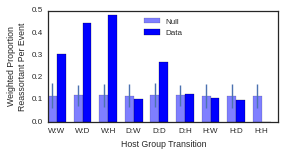

In [18]:
fig = plt.figure(figsize=(4,2))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, color='blue', label='Null', yerr=np.array(stds)*5, alpha=0.5)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names)
ax.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax.set_xlabel('Host Group Transition')
ax.legend(loc='upper center')
plt.subplots_adjust(left=0.15, right=0.95)
plt.savefig('figures/Proportion Reassortant Ecological.pdf')
plt.show()

In [19]:
np.array(means) - np.array(data)

array([-0.187693  , -0.32302448, -0.36024826,  0.01521349, -0.14983664,
       -0.00618505,  0.00851666,  0.01791293,  0.11685636])